In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlalchemy

from database_credentials import get_database_url
from load_drop_data import (
    load_week_n_sell_data,
    drop_incomplete_sell_data
)

In [22]:
def date_to_weekday_am_pm(date):
    """Convert date to weekday followed by AM or PM
    
    Args:
        date (datetime): date when a given turnip price was observed
        
    Returns:
        weekday_am_pm (str): weekday AM/PM e.g. 'Monday AM'
    """
    
    weekday = date.strftime('%A')
    time_of_day = date.strftime('%p')
    
    weekday_am_pm = weekday + ' ' + time_of_day
    return weekday_am_pm

def datetime_to_weekday(data):
    """Use the column datetime_observed and function date_to_weekday_am_pm 
    to create the column weekday_observed
    
    Args:
        data (datetime): 
            contains turnip selling prices loaded into a dataframe using 
            get_week_n_sell_data
        
    Returns:
        data (dataframe): 
            contains the original data in addition to a column indicating 
            the weekday and time of day (AM/PM) for each price observation 
    """
    
    weekday_observed = data['datetime_observed'].apply(date_to_weekday_am_pm)
    data['weekday_observed'] = weekday_observed
    return data

def pivot(data):
    """Pivot the data

    Args:
        data (dataframe):
            contains user_id, island_id, turnip selling prices along with 
            weekday_observed
    
    Returns:
        pivot_table (dataframe):
            pivot table of the data with incremented indices in place of 
            user_id and island_id
         _________________________________________________________________
        |   -   | Monday AM | Monday PM | ... | Saturday AM | Saturday PM |
        | index |     -     |     -     | ... |      -      |      -      |
        |   0   |   price   |   price   | ... |    price    |    price    |
    """
    
    pivot_table = pd.pivot_table(
        data=data,
        values='price',
        index=['user_id', 'island_id'],
        columns='weekday_observed'
    )
    
    # correct weekday order
    column_names = data['weekday_observed'].unique()
    pivot_table = pivot_table.reindex(column_names, axis=1)
    
    # drop user_id, island_id
    pivot_table.reset_index(drop=True, inplace=True)
    
    return pivot_table

def combine(list_of_data):
    """Combine weekly turnip prices
    
    Args:
        list_of_data (list): 
            contains price data for various weeks
        
    Returns:
        combined_data (dataframe): 
            contains turnip prices with each weekly trend identified
            by indices
    """
    
    pivot_tables = [pivot(data) for data in list_of_data]
    
    combined_data = pd.concat(pivot_tables)
    combined_data.reset_index(drop=True, inplace=True)
    combined_data.reset_index(inplace=True)
    
    combined_data = combined_data.melt(
        id_vars='index',
        value_name='price'
    )

    combined_data.reset_index(drop=True, inplace=True)
    
    return combined_data

In [3]:
plt.style.use('ggplot')
sns.set_style('white')

In [4]:
database_url = get_database_url()
engine = sqlalchemy.create_engine(database_url)
connection = engine.connect()

In [13]:
num_weeks = 3

sell_data = [
    load_week_n_sell_data(week=week_num, connection=connection) 
    for week_num in range(1, num_weeks + 1)
]
    
sell_data = [drop_incomplete_sell_data(data) for data in sell_data]
    
sell_data = [datetime_to_weekday(data) for data in sell_data]

In [25]:
combined_sell_data = combine(sell_data)
xticks = combined_sell_data['weekday_observed'].unique()

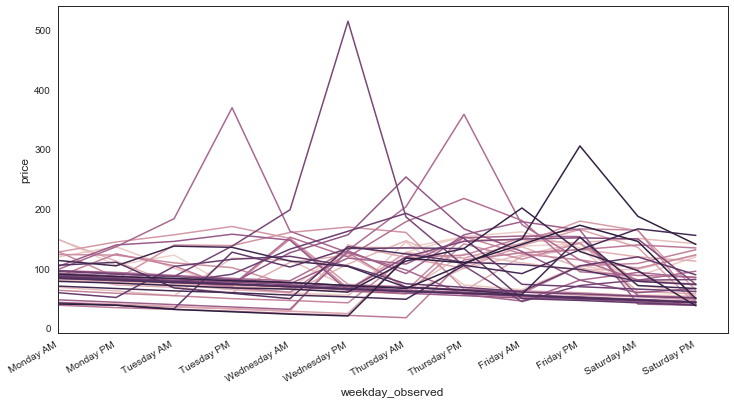

In [10]:
plt.figure(figsize=(12, 6))
combined_sell_data_plot = sns.lineplot(
    x='weekday_observed', 
    y='price', 
    hue='index',
    data=combined_sell_data, 
    sort=False,
    legend=False
)

combined_sell_data_plot.set_xticklabels(xticks, rotation=30, ha='right')
plt.xlim(0, )
plt.show()